# Лабораторная работа №7 ("Проведение исследований с моделями семантической сегментации")

In [ ]:
import torch
import torch.nn
import torch.optim
import torch.utils.data
import datasets
import torchvision.transforms
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchinfo
import albumentations
from PIL import Image

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Выбор начальных условий

Для решения задачи семантической сегментации на основе визуальных данных я выбрал датасет из прошлой лабораторной — [`Nfiniteai/product-masks-sample`](https://huggingface.co/datasets/Nfiniteai/product-masks-sample). Данный датасет включает изображения, созданные на основе 3D-моделей предметов домашнего интерьера (мебель, элементы декора и т.д.). Благодаря фотореалистичной визуализации он подходит для обучения моделей, требующих работы с реалистичными сценами.

В контексте семантической сегментации набор может быть полезен для автоматизации инвентаризации — например, для разработки системы, которая распознаёт объекты через камеру в реальном времени и фиксирует их наличие/местоположение.
Загрузим датасет и выведем примеры изображений с метками.

In [ ]:
dataset = datasets.load_dataset('Nfiniteai/product-masks-sample')

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Validation dataset size: {len(dataset['val'])}")

print('Features:')
for feature_name, feature_type in dataset['train'].features.items():
    print(f'{feature_name}: {feature_type}')

README.md:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

train-00000-of-00014.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

train-00001-of-00014.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00002-of-00014.parquet:   0%|          | 0.00/283M [00:00<?, ?B/s]

train-00003-of-00014.parquet:   0%|          | 0.00/305M [00:00<?, ?B/s]

train-00004-of-00014.parquet:   0%|          | 0.00/298M [00:00<?, ?B/s]

train-00005-of-00014.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

train-00006-of-00014.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00007-of-00014.parquet:   0%|          | 0.00/253M [00:00<?, ?B/s]

train-00008-of-00014.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00009-of-00014.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

train-00010-of-00014.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

train-00011-of-00014.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00012-of-00014.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

train-00013-of-00014.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2559 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/151 [00:00<?, ? examples/s]

Train dataset size: 2559
Validation dataset size: 151
Features:
image_id: Value(dtype='string', id=None)
image: Image(mode=None, decode=True, id=None)
mask: Image(mode=None, decode=True, id=None)
category: Value(dtype='string', id=None)
bbox: Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)
product_id: Value(dtype='string', id=None)
scene_id: Value(dtype='string', id=None)


### Выбор метрик

При оценке моделей семантической сегментации критически важно подбирать метрики, учитывающие специфику задачи: многоклассовость, пространственное распределение объектов и дисбаланс классов.

В качестве ключевой метрики был выбран **IoU** (Intersection over Union). Он вычисляется как отношение площади пересечения предсказанной и истинной областей к площади их объединения для каждого класса. Этот показатель эффективно отражает точность локализации объектов, что особенно важно в задачах сегментации.

От использования Accuracy было решено отказаться. В задачах сегментации фон часто занимает большую часть изображения, что приводит к парадоксу: модель может достигать высокой точности, просто помечая всё как фон, при этом игнорируя второстепенные классы. Это делает Accuracy неинформативной для объективной оценки.

## Создание бейзлайна и оценка качества

Аналогично с прошлой лабораторной работой, сделаем минимальное преобразование скачанного датасета, чтобы он был пригоден для обучения модели.

Для этого сделаем нормализацию названий классов и уберем из тренировочной выборки записи,  в которых есть не предусмотренные в валидационной выборке классы. И уберем все лишние поля, которые не понадобятся при обучении, чтобы экономить ресурсы.

In [ ]:
val_dataset = dataset['val']
train_dataset = dataset['train']

In [ ]:
def preprocess_category(category):
    return category.lower().replace(' ', '_')

def preprocess_category_batch(batch):
    batch['category'] = [preprocess_category(el) for el in batch['category']]
    return batch

val_dataset = val_dataset.map(
    preprocess_category_batch,
    load_from_cache_file=False,
    batched=True,
    batch_size=300,
    writer_batch_size=300,
)

train_dataset = train_dataset.map(
    preprocess_category_batch,
    load_from_cache_file=False,
    batched=True,
    batch_size=300,
    writer_batch_size=300,
)

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/2559 [00:00<?, ? examples/s]

Выполним фильтрацию фичей в датасете, оставив только те, которые нам необходимы для обучения модули для решения задачи классификации. После применения изменений останутся только следующие поля:
- `image` - данное поле содержит целевое изображение
- `category` - данное поле содержит название класса в текстовом формате
- `mask` - данное поле содержит маску, которая представляет собой черно-белое изображение, каждый пиксель которого описывает степень его принадлежности к рассматриваемому классу
- `bbox` - координаты boundary box, в котором находится целевой объект. Данная информация будет необходима при улучшении бейзлайна.

In [ ]:
include_features = {'image', 'bbox', 'category', 'mask'}
all_features = set(train_dataset.features)
exclude_features = all_features - include_features

train_dataset = train_dataset.remove_columns(exclude_features)
val_dataset = val_dataset.remove_columns(exclude_features)

train_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'mask': Image(mode=None, decode=True, id=None),
 'category': Value(dtype='string', id=None),
 'bbox': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)}

Теперь, чтобы не обучать модель определять классы, которых нет в валидационной выборке, уберем из тренировочной выборки те записи, которые соответствуют таким классам. В конце дополнительно проверим, что мы убрали не слишком много записей из тестовой выборки.

Также, соотнесем с каждым классов уникальный численный идентификатор. Для обозначения фона добавим специальный класс `<BACKGROUND>`.

In [ ]:
categories = set(val_dataset['category'])
categories = {category: index for index, category in enumerate(categories)}
categories['<BACKGROUND>'] = len(categories)

train_dataset = train_dataset.filter(
    lambda category: category in categories,
    load_from_cache_file=False,
    writer_batch_size=300,
    input_columns=['category'],
)

print(len(train_dataset))

Filter:   0%|          | 0/2559 [00:00<?, ? examples/s]

2063


Также для преобразования данных к виду, пригодному для подачи на вход в модель, создадим класс датасета `SegmentationDataset`. Данный датасет на основе переданного исходного датасета возьмет информацию об изображении, классе и маске, предобработает их и вернет значения в формате двойки `(image, mask)`, где `image` - PyTorch тензор размерности $(3 \times W \times H)$, описывающий изображение, и `mask` - тензор размерности $(W \times H)$, содержащий целые числа, играющие роль числовых идентификаторов классов.

Класс также поддерживает внедрение пользовательских трансформаций через параметр `transform` в конструкторе класса, что понадобится в будущем для улучшения бейзлайная через аугментацию.

Отдельно рассмотрим работу функции `transform_mask`, которая ответственна за предобработку изображения маски к виду, пригодному для использования при обучении модели. Данная функция преобразует входное черно-белое изображение маски к матрице размерности $(W \times H)$, каждый элемент которой представляет целое число, обозначающее идентификатор класса, которому принадлежит текущий пиксель. Все фоновые пиксели мы помечаем числом, соответствующим классу `<BACKGROUND>`.

In [ ]:
transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


def transform_mask(mask, class_index, *, threshold=0.5, classes_amount=1):
    mask = mask.resize((224, 224))
    mask_np = np.array(mask).astype(np.float32) / 255.0

    object_mask = (mask_np >= threshold).astype(int) * class_index
    background_mask = (mask_np < threshold).astype(int) * categories['<BACKGROUND>']
    total_mask = object_mask + background_mask

    return torch.from_numpy(total_mask)


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, categories, *, max_len=None, transform=None, threshold=0.5):
        self._dataset = dataset
        self._categories = categories
        self._max_len = float('inf') if max_len is None else max_len
        self._threshold = threshold
        self._transform = transform or (lambda x, bbox, y: (x, y))

    def __len__(self):
        return min(len(self._dataset), self._max_len)

    def __getitem__(self, idx):
        example = self._dataset[idx]
        image, mask = example['image'].convert('RGB'), example['mask']
        class_index = self._categories[example['category']]
        bbox = example['bbox']

        image, mask = self._transform(image, bbox, mask)

        image = transform_image(image)
        mask = transform_mask(
            mask,
            class_index,
            threshold=self._threshold,
            classes_amount=len(self._categories),
        )

        return image, mask

Перейдем теперь к этапу обучения модели. Для этого создадим вспомогательные функции:
- `train_model` - отвечает за процесс обучения модели. Данная функция написана таким образом, чтобы по завершению каждого шага возвращать промежуточные данные, информирующие пользователя о текущем номере шага, эпохи и значении ошибки на текущем этапе обучения;
- `eval_model` - отвечает за процесс валидации модели. Данная функция принимает на вход словарь метрик, и на его основе рассчитывает значения целевых метрик на валидационном датасете для обученной модели.

Также, для подсчета значения метрик создадим вспомогательную функцию `_calculate_metrics`. Данная функция принимает на вход вероятности, подсчитанные моделью, ожидаемые маски и словарь метрик. Перед тем как подавать на вход значения в функции метрик, функция подсчитывает статистику $TP, FP, FN, TN$, на основе которой и будут подсчитаны метрики. Стоит отметить, что при подсчете статистики игнорируется класс `<BACKGROUND>`. Это необходимо для того, чтобы пир подсчете метрик мы не учитывали пиксели, соответствующие заднему фону, так как он обычно занимает основную часть изображения.

In [ ]:
DEVICE = "cuda"

In [ ]:
def _calculate_metrics(outputs, masks, metrics):
    predicted_classes = outputs.argmax(dim=1)
    tp, fp, fn, tn = smp.metrics.get_stats(
        predicted_classes, masks,
        mode='multiclass',
        num_classes=len(categories) - 1,
        ignore_index=categories['<BACKGROUND>'],
    )

    return {
        metric_name: metric_function(tp, fp, fn, tn).item()
        for metric_name, metric_function in metrics.items()
    }


def train_model(model, dataset, loss, optimizer, *, num_epochs=1):
    model.train()

    total_loss = 0.0
    total_size = 0

    for epoch in range(1, num_epochs + 1):
        for step_number, (images, masks) in enumerate(dataset, 1):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)

            loss_value = loss(outputs, masks)
            loss_value.backward()
            optimizer.step()

            batch_size = images.size()[0]
            total_loss += loss_value.item() * batch_size
            total_size += batch_size

            yield {
                'epoch': epoch,
                'step': step_number,
                'loss': total_loss / total_size,
            }


def eval_model(model, ds, metrics):
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, masks in ds:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)

            all_labels.append(masks.cpu())
            all_preds.append(outputs.cpu())

    all_labels = torch.cat(all_labels, dim=0)
    all_preds  = torch.cat(all_preds, dim=0)

    return _calculate_metrics(all_preds, all_labels, metrics)

Также, для визуальной проверки работоспособности обученной модели напишем функцию `test_model`, которая визуально отображает маску, предсказанную моделью, и ожидаемую маску для класса `category_index`, объект которого находится на целевом изображении.

In [ ]:
def test_model(model, image, mask, category_index):
    model.eval()
    with torch.no_grad():
        C, W, H = image.shape
        image = image.resize(1, C, W, H)
        image = image.to(DEVICE)
        preds = model(image)[0].cpu()

    predicted_mask = torch.argmax(preds, dim=0).numpy()
    predicted_mask = (predicted_mask == category_index).astype(np.uint8) * 255

    predicted_mask_image = Image.fromarray(predicted_mask, mode='L')
    mask_image = Image.fromarray((mask.numpy() == category_index).astype(np.uint8) * 255, mode='L')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(mask_image)

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask_image)

    plt.show()

Опишем набор метрик, которые мы будем использовать для оценки качества обученной модели. Как и было описано выше, мы будем использовать только метрику IoU, так как она наиболее информативная.

In [ ]:
metrics = {
    'iou': lambda tp, fp, fn, tn: smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro'),
}

### Обучение модели CNN

Для начала обучим на бейзлайне сверточную нейронную сеть. Для этого возьмем предобученную модель архитектуры U-Net и в качестве энкодера выберем модель архитектуры ResNet18. Веса возьмем, полученные при обучении модели на датасете ImageNet.

Использование предобученного энкодера позволяет эффективно извлекать информативные признаки из изображений, тем самым позволяя ускорить обучение и повысить качество семантической сегментации.

Так как мы работает с RGB изображениями, то при инициализации модели необходимо установить параметру `in_channels` значение `3`. Также, так как мы решаем задачу мультиклассовой классификации, то необходимо указать количество предсказываемых классов в параметре `classes`.

In [ ]:
model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
)

torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
├─UnetDecoder: 1

In [ ]:
train_ds = SegmentationDataset(train_dataset, categories)
val_ds = SegmentationDataset(val_dataset, categories)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = model.to(DEVICE)

for _ in range(3):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=1.8913665073171036
Eval results: iou:0.2849
Step [129 / 129], loss=1.7431290852347457
Eval results: iou:0.2935
Step [129 / 129], loss=1.6560381895352845
Eval results: iou:0.3154


На основе приведенных результатов обучения модели на бейзлайне для задачи семантической сегментации изображений можно сделать следующие выводы.

Хотя значение ошибки и уменьшается с каждой эпохой, что является признаком того, что модель еще способна к обучению, однако скорость сходимости довольно низкая.

Показатели метрики IoU оказались относительно низкими для задачи семантической сегментации.

Итого, модель показала не очень хорошие результаты, но постепенное уменьшение значения ошибки и рост показаний метрики IoU показывают, что модель имеет потенциал для улучшения. Возможно, при улучшении бейзлайна стоит увеличить число эпох.

### Обучение трансформерной модели

Обучим теперь на бейзлайне модель, основанную на трансформерной архитектуре. Для этого я выбрал модель на архитектуре `SegFormer`. В качестве энкодера используем легкую и быструю модификацию — `MiT-B0`. Мы также инициализируем энкодер предобученными весами, полученными на датасете `ImageNet`.

Так как мы также работаем с RGB изображениями, параметр `in_channels` устанавливается в значение `3`. А параметр `classes` устанавливается равным количеству сегментируемых классов, определяемому переменной `categories`.

In [ ]:
model = smp.Segformer(
    encoder_name='mit_b0',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
)

torchinfo.summary(model)

config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Layer (type:depth-idx)                        Param #
Segformer                                     --
├─MixVisionTransformerEncoder: 1-1            --
│    └─OverlapPatchEmbed: 2-1                 --
│    │    └─Conv2d: 3-1                       4,736
│    │    └─LayerNorm: 3-2                    64
│    └─OverlapPatchEmbed: 2-2                 --
│    │    └─Conv2d: 3-3                       18,496
│    │    └─LayerNorm: 3-4                    128
│    └─OverlapPatchEmbed: 2-3                 --
│    │    └─Conv2d: 3-5                       92,320
│    │    └─LayerNorm: 3-6                    320
│    └─OverlapPatchEmbed: 2-4                 --
│    │    └─Conv2d: 3-7                       368,896
│    │    └─LayerNorm: 3-8                    512
│    └─Sequential: 2-5                        --
│    │    └─Block: 3-9                        79,616
│    │    └─Block: 3-10                       79,616
│    └─LayerNorm: 2-6                         64
│    └─Sequential: 2-7               

In [ ]:
train_ds = SegmentationDataset(train_dataset, categories)
val_ds = SegmentationDataset(val_dataset, categories)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = model.to(DEVICE)

for _ in range(3):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=1.7637385077113615
Eval results: iou:0.3675
Step [129 / 129], loss=1.5641648160330717
Eval results: iou:0.2546
Step [129 / 129], loss=1.4274902436205097
Eval results: iou:0.3557


На основе приведенных результатов обучения модели на бейзлайне для задачи семантической сегментации изображений можно сделать следующие выводы.

На второй эпозе заметно колебание, проявляющееся в виде падения метрики IoU. Это может быть связано с начальной адаптацией трансформерной архитектуры к задаче.

Модель, основанная на архитектуре `SegFormer` на базе `MiT-B0` показывает более высокое качество сегментации и обучается эффективнее в сравнении со сверточной моделью `U-Net` с энкодером `ResNet18`.

Итоговые значения метрики IoU указывают на то, что модель показывает обещающие результаты, но модель все также нуждается в улучшении бейзлайна.



## Улучшение бейзлайна

### Обрезка изображений

Одной из проблем, которые присущи текущему бейзлайну, является то, что задний фон занимает основное пространство на изображении, из-за чего доля пикселей, относящихся к объекту на изображении становится слишком маленькой.

Так как пиксели, относящиеся к заднему фону, нас не особо интересуют, попробуем убрать их. Для этого воспользуемся информацией из `bbox` и "обрежем" изображение вместе с маской, оставив только ту часть, в которой находится наш целевой объект.

На обрезанной фотографии доля пикселей, относящихся к объекту, будет уже гораздо больше, что теоретически должно положительно сказаться на обучении модели.

Для этого реализуем функцию `crop_image`, которая на основе переданной информации о координатах `bbox` будет осуществлять обрезку фотографии, и передадим ее на вход конструкторам датасетов.

In [ ]:
def crop_image(image, bbox, mask):
    x, y, w, h = bbox
    cropped_image = image.crop((x, y, x + w, y + h))
    cropped_mask = mask.crop((x, y, x + w, y + h))
    return cropped_image, cropped_mask


train_ds = SegmentationDataset(train_dataset, categories, transform=crop_image)
val_ds = SegmentationDataset(val_dataset, categories, transform=crop_image)

Попробуем обучить на улучшенном бейзлайне сверточную модель.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.0427937555012633
Eval results: iou:0.2471
Step [129 / 129], loss=1.8433424963051985
Eval results: iou:0.3096
Step [129 / 129], loss=1.7586301685708627
Eval results: iou:0.3299
Step [129 / 129], loss=1.6007164526147514
Eval results: iou:0.3531
Step [129 / 129], loss=1.4575496708485785
Eval results: iou:0.3543


Визуально проверим, как модель на данный момент справляется с задачей семантической сегментации

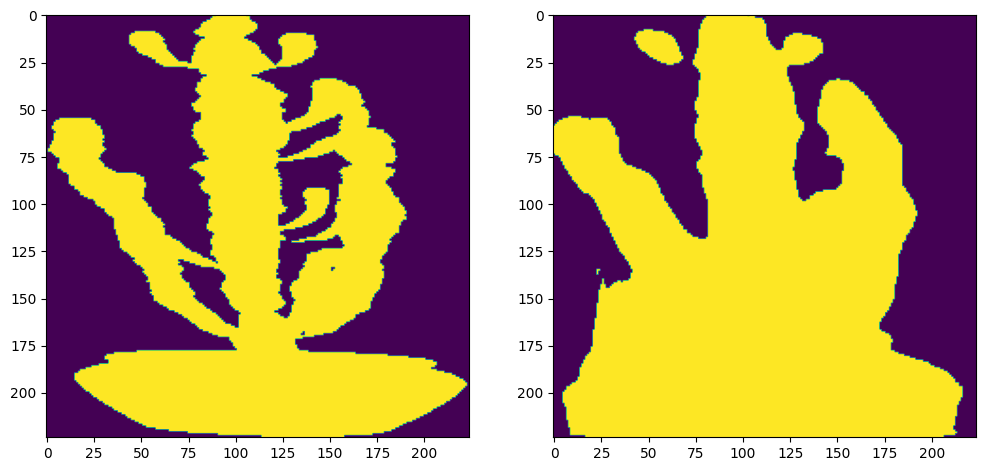

In [ ]:
test_model(model, *val_ds[0], categories[val_dataset[0]['category']])

Попробуем теперь обучить на улучшенному бейзлайне трансформерную модель

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = smp.Segformer(
    encoder_name='mit_b0',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.2057004447591236
Eval results: iou:0.2045
Step [129 / 129], loss=2.0618190975716204
Eval results: iou:0.2733
Step [129 / 129], loss=1.9261241693029807
Eval results: iou:0.2829
Step [129 / 129], loss=1.8515174584196887
Eval results: iou:0.2911
Step [129 / 129], loss=1.8406252714250484
Eval results: iou:0.3157


Визуально проверим, как модель на данный момент справляется с задачей семантической сегментации

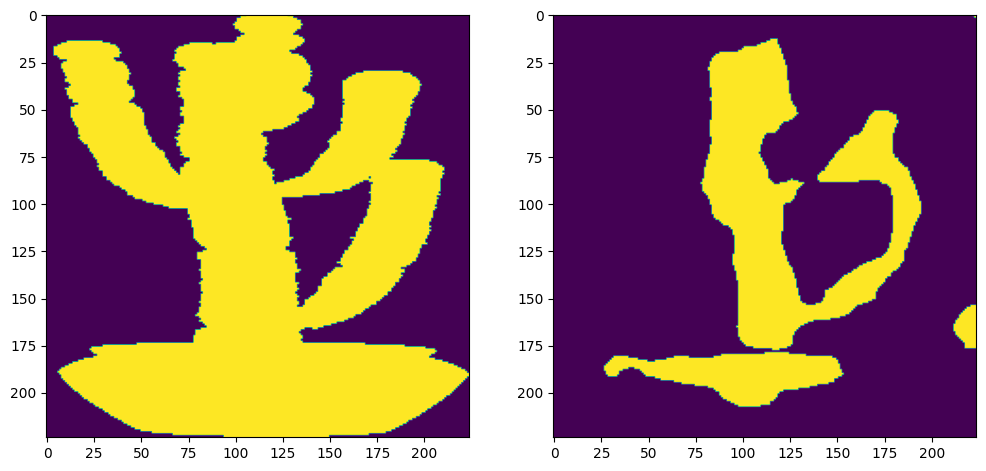

In [ ]:
index = 20
test_model(model, *val_ds[index], categories[val_dataset[index]['category']])

Как видим, обрезка изображения по bounding box дала положительный результат только для сверточной модели. Показатели трансформерной модели, наоборот, немного ухудшились.

### Аугментация

Вторая гипотеза по улучшению бейзлайна состоит в использовании техники аугментации данных, которая направлена на повышение обобщающей способности модели.

Для этого создадим последовательность преобразований `_augmetn`, которая будет включать в себя:
- Случайное горизонтальное отражение;
- Случайное вращение изображения на угол до 15 градусов.

Так как нам необходимо выполнить одинаковые преобразования как для изображения, так и для маски, то воспользуемся в этот раз библиотекой `albumentations`, которая позволяет указать дополнительное изображения, к которому будут применены те же преобразования, что и к целевому входному изображению.

In [ ]:
_augment = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(limit=15, p=0.5),
    ],
    additional_targets={'mask': 'mask'},
)


def augment_pair(image, mask):
    image = np.array(image)
    mask = np.array(mask)

    augmented = _augment(image=image, mask=mask)
    return Image.fromarray(augmented['image']), Image.fromarray(augmented['mask'])


def transform(image, bbox, mask):
    image, mask = augment_pair(image, mask)
    return crop_image(image, bbox, mask)


train_ds = SegmentationDataset(train_dataset, categories, transform=transform)
val_ds = SegmentationDataset(val_dataset, categories, transform=crop_image)

Попробуем обучить на улучшенном бейзлайне сверточную модель.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=1.9741288213780708
Eval results: iou:0.3281
Step [129 / 129], loss=1.7657065480297423
Eval results: iou:0.3711
Step [129 / 129], loss=1.5433257452908847
Eval results: iou:0.3844
Step [129 / 129], loss=2.4801414508005977
Eval results: iou:0.4056
Step [129 / 129], loss=1.3545117314903123
Eval results: iou:0.4123


Визуально проверим, как модель на данный момент справляется с задачей семантической сегментации

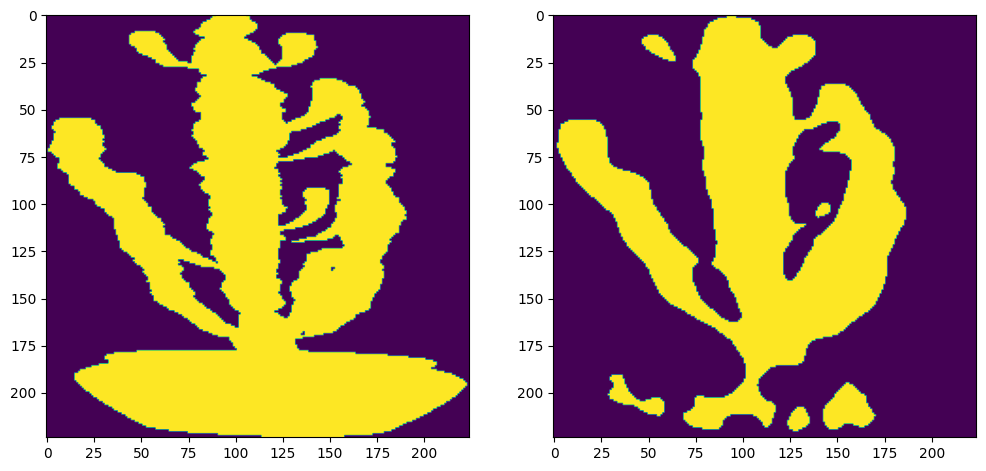

In [ ]:
test_model(model, *val_ds[0], categories[val_dataset[0]['category']])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = smp.Segformer(
    encoder_name='mit_b0',
    encoder_weights='imagenet',
    in_channels=3,
    classes=len(categories),
).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.5233388603051427
Eval results: iou:0.1611
Step [129 / 129], loss=2.2768655347292487
Eval results: iou:0.1830
Step [129 / 129], loss=2.1657169722956013
Eval results: iou:0.2134
Step [129 / 129], loss=1.9181014840370582
Eval results: iou:0.2828
Step [129 / 129], loss=1.8237502788260796
Eval results: iou:0.3042


Визуально проверим, как модель на данный момент справляется с задачей семантической сегментации

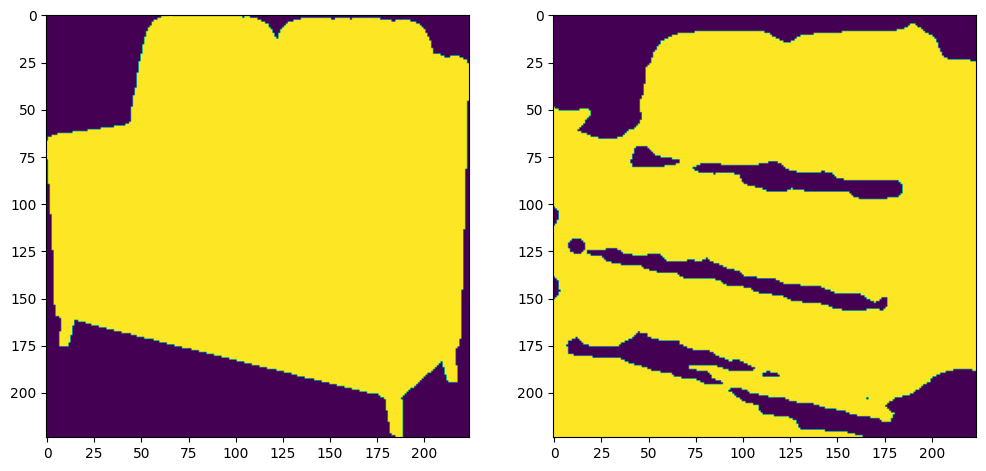

In [ ]:
test_model(model, *val_ds[24], categories[val_dataset[24]['category']])

Аналогично с применением обрезки изображений, применение аугментации дало положительный результат только для сверточной модели, в то время как для трансформерной модели, наоборот, сделало результаты немного хуже.

Итого, можно сказать, что методы улучшения бейзлайна, которые были применены, позволили улучшить качество модели на базе архитектуры U-Net, однако, не оказали положительных результатов для модели на базе архитектуры Segformer.

## Имплементация алгоритма машинного обучения

### Сверточная модель

Перейдем теперь к имплементации сверточной модели для решения задачи семантической сегментации. Так как архитектура U-Net значительно сложнее архитектуры простой сверточной модели для решения задачи классификации, то мы в этот раз опишем ее в виде класса `UNetImplementation`.

При реализации я придерживался того, чтобы дать возможность гибко настраивать архитектуру с помощью конфигурации слоёв. Это делает реализацию более универсальной и адаптируемой под различные датасеты и ресурсы.

Во входной конфигурации каждый уровень описывается словарём с параметрами количества входных и выходных каналов:
- `in_channels` - описывает количество входных каналов на данном уровне;
- `out_channels` - описывает количество выходных каналов на данном уровне.

Параметр конструктора `num_classes` описывает количество классов, предсказываемых моделью. Этот параметр используется на финальном слое классификации.

Сама модель состоит из следующих компонентов:
1. **Энкодер**. Этот компонент включает в себя набор свёрточных блоков с функцией ReLU и последующей операцией пула. Данный компонент используется для извлечения признаков и уменьшения разрешения изображения.
2. **Боттлнек**. Этот компонента представляет центральную часть U-Net. В нем происходит наибольшее сжатие. Также, здесь происходит увеличение глубины признаков в два раза по сравнению с последним энкодерным уровнем.
3. **Декодер**. В данном компоненте каждый уровень включает транспонированную свёртку, которая необходима для увеличения разрешения, и блок свёрток с пропущенным соединением из соответствующего уровня энкодера.
4. **Финальный слой**. Последний компонент, который содержит одноканальную свёртку, которая преобразует результат к требуемому количеству классов.

Наконец, в методе `forward` описана основная логика того, как модель обрабатывает входные данные и формирует предсказания для каждого пикселя:
- в энкодере формируются карты признаков;
- они сохраняются для использования в skip-соединениях;
- в декодере происходит объединение апсемплированных карт признаков с соответствующими энкодерными;
- на выходе возвращается маска с предсказаниями для каждого пикселя.

In [ ]:
class UNetImplementation(torch.nn.Module):
    def __init__(self, layers_config, num_classes):
        super().__init__()

        self._encoder_blocks = torch.nn.ModuleList()
        self._downsampling_layers = torch.nn.ModuleList()

        for layer in layers_config:
            self._encoder_blocks.append(
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        layer['in_channels'],
                        layer['out_channels'],
                        kernel_size=3,
                        padding=1,
                    ),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(
                        layer['out_channels'],
                        layer['out_channels'],
                        kernel_size=3,
                        padding=1,
                    ),
                    torch.nn.ReLU(),
                )
            )
            self._downsampling_layers.append(torch.nn.MaxPool2d(kernel_size=2))

        bottleneck_in = layers_config[-1]['out_channels']
        bottleneck_out = bottleneck_in * 2

        self._bottleneck_block = torch.nn.Sequential(
            torch.nn.Conv2d(
                bottleneck_in,
                bottleneck_out,
                kernel_size=3,
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                bottleneck_out,
                bottleneck_out,
                kernel_size=3,
                padding=1,
            ),
            torch.nn.ReLU(),
        )

        self._upsampling_layers = torch.nn.ModuleList()
        self._decoder_blocks = torch.nn.ModuleList()
        reversed_config = list(reversed(layers_config))

        for layer in reversed_config:
            self._upsampling_layers.append(
                torch.nn.ConvTranspose2d(
                    bottleneck_out,
                    layer['out_channels'],
                    kernel_size=2,
                    stride=2,
                ),
            )

            self._decoder_blocks.append(
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        layer['out_channels'] * 2,
                        layer['out_channels'],
                        kernel_size=3,
                        padding=1,
                    ),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(
                        layer['out_channels'],
                        layer['out_channels'],
                        kernel_size=3,
                        padding=1,
                    ),
                    torch.nn.ReLU(),
                )
            )

            bottleneck_out = layer['out_channels']

        self._final_convolution = torch.nn.Conv2d(
            layers_config[0]['out_channels'],
            num_classes,
            kernel_size=1,
        )

    def forward(self, input_tensor):
        encoder_feature_maps = []
        x = input_tensor

        for encoder_block, downsample in zip(self._encoder_blocks, self._downsampling_layers):
            x = encoder_block(x)
            encoder_feature_maps.append(x)
            x = downsample(x)

        x = self._bottleneck_block(x)

        for index in range(len(self._upsampling_layers)):
            x = self._upsampling_layers[index](x)
            skip_connection = encoder_feature_maps[-(index + 1)]
            x = self._decoder_blocks[index](torch.cat([x, skip_connection], dim=1))

        return self._final_convolution(x)


Попробуем обучить собственную имплементацию сверточной модели на бейзлайне

In [6]:
train_ds = SegmentationDataset(train_dataset, categories)
val_ds = SegmentationDataset(val_dataset, categories)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

config = [
    {'in_channels': 3, 'out_channels': 64},
    {'in_channels': 64, 'out_channels': 128},
]
model = UNetImplementation(config, num_classes=len(categories)).to(DEVICE)

for _ in range(3):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.627028914718332
Eval results: iou:0.07498
Step [129 / 129], loss=1.88083767602008
Eval results: iou:0.1852
Step [129 / 129], loss=1.8235164939114843
Eval results: iou:0.2034


Теперь, попробуем обучить собственную имплементацию сверточной модели на улучшенном бейзлайне

In [7]:
train_ds = SegmentationDataset(train_dataset, categories, transform=transform)
val_ds = SegmentationDataset(val_dataset, categories, transform=crop_image)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = UNetImplementation(config, num_classes=len(categories)).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.2212896180626727
Eval results: iou:0.1479
Step [129 / 129], loss=1.987437465615025
Eval results: iou:0.2144
Step [129 / 129], loss=1.9555296294618683
Eval results: iou:0.2162
Step [129 / 129], loss=1.842172718001868
Eval results: iou:0.2098
Step [129 / 129], loss=1.732879776152603
Eval results: iou:0.2157


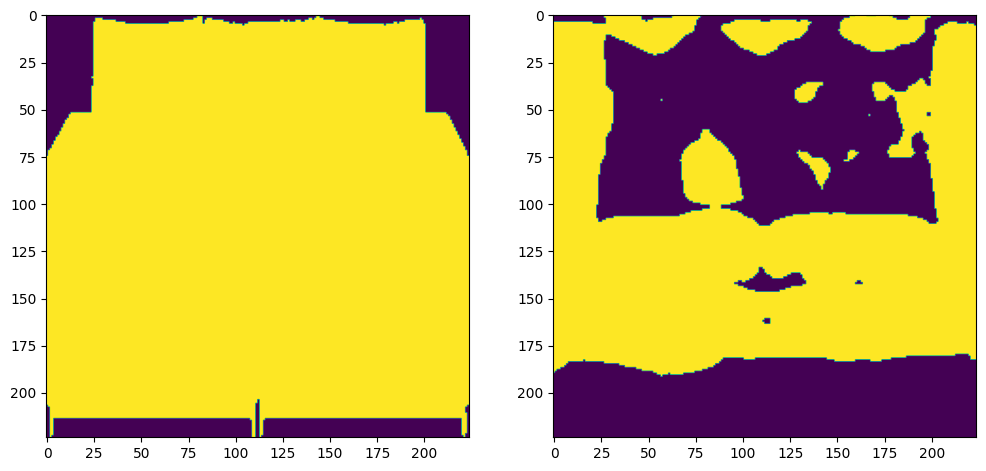

In [ ]:
test_model(model, *train_ds[13], categories[train_dataset[13]['category']])

Как видно, модель показала относительно хуже результаты на бейзлайне по сравнению с моделью U-Net. Использование улучшенного бейзлайна не дало особых результатов.

Возможной причиной может послужить то, что модель UNet уже была обучена на богатом датасете. Как следствие, она содержит богатые и универсальные признаки, по сравнению с собственной имплементацией, которая обучалась с нуля.

Также возможной причиной может послужить то, что собственная имплементация не такая глубокая и не имеет такую сложную архитектуру, как модель UNet.

### Трансформерная модель

Перейдем теперь к собственной имплементации трансформерной модели. Так как и здесь, описание трансформерной модели для решения задачи семантической сегментации значительно сложнее по сравнению с задачей классификации, то в этот раз опишем модели в виде классов.

Модель декомпозирована на основные компоненты:
- `PatchEmbedding` - данный компонент разбивает входное изображение на патчи фиксированного размера и проектирует их в векторное пространство заданной размерности с помощью свертки.
- `TransformerEncoderBlock` - представляет собой набор блоков энкодера. Каждый блок энкодера содержит:
  - **Layer Normalization** - нормализация входа.
  - **Multi-Head Attention** - применяется внимание, позволяющее учитывать зависимости между всеми патчами изображения.
  - **MLP-блок** - состоит из двух полносвязных слоев с функцией активации GELU и дропаутом.
  - Используется **резидуальное соединение** после каждого подблока для стабилизации градиентов.
- `TransformerSegmentationModel` - собирает все компоненты в одно целое.

In [ ]:
class PatchEmbedding(torch.nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.projection = torch.nn.Conv2d(
            in_channels,
            emb_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        x = self.projection(x)
        batch_size, channels, height, width = x.shape
        x = x.flatten(2).transpose(1, 2)

        return x


class TransformerEncoderBlock(torch.nn.Module):
    def __init__(self, emb_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.layer_norms = torch.nn.ModuleList([
            torch.nn.LayerNorm(emb_dim),
            torch.nn.LayerNorm(emb_dim)
        ])

        self.attention = torch.nn.MultiheadAttention(
            emb_dim,
            num_heads,
            dropout=dropout,
            batch_first=True,
        )

        hidden_dim = int(emb_dim * mlp_ratio)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, emb_dim),
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attention(self.layer_norms[0](x), x, x)[0]
        x = x + self.mlp(self.layer_norms[1](x))

        return x


class TransformerSegmentationModel(torch.nn.Module):
    def __init__(
        self,
        in_channels=3,
        num_classes=1,
        patch_size=16,
        emb_dim=256,
        depth=6,
        num_heads=8,
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_dim)

        self.blocks = torch.nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads)
            for _ in range(depth)
        ])

        num_patches = (224 // patch_size) ** 2
        self.position_embedding = torch.nn.Parameter(
            torch.zeros(1, num_patches, emb_dim)
        )

        self.reconstruction = torch.nn.ConvTranspose2d(
            emb_dim,
            num_classes,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.patch_embed(x)
        x = x + self.position_embedding

        for block in self.blocks:
            x = block(x)

        spatial_dim = int((x.size(1)) ** 0.5)
        x = x.transpose(1, 2).reshape(batch_size, -1, spatial_dim, spatial_dim)
        x = self.reconstruction(x)

        return x

Попробуем обучить собственную имплементацию трансформерной модели на бейзлайне

In [8]:
train_ds = SegmentationDataset(train_dataset, categories)
val_ds = SegmentationDataset(val_dataset, categories)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = TransformerSegmentationModel(num_classes=len(categories)).to(DEVICE)

for _ in range(3):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=3.104461310502689
Eval results: iou:0.1175
Step [129 / 129], loss=2.778125865518382
Eval results: iou:0.1523
Step [129 / 129], loss=2.571135988549821
Eval results: iou:0.1532


Теперь, попробуем обучить модель на улучшенном бейзлайне

In [9]:
train_ds = SegmentationDataset(train_dataset, categories, transform=transform)
val_ds = SegmentationDataset(val_dataset, categories, transform=crop_image)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

model = TransformerSegmentationModel(num_classes=len(categories)).to(DEVICE)

for _ in range(5):
    train_logs = train_model(
        model,
        train_loader,
        torch.nn.CrossEntropyLoss(ignore_index=categories['<BACKGROUND>']),
        torch.optim.Adam(model.parameters(), lr=1e-3),
    )

    for log in train_logs:
        print(
            '\rStep [{step} / {steps_amount}], loss={loss}'.format(
                step=log['step'],
                steps_amount=len(train_loader),
                loss=log['loss'],
            ),
            end='',
        )

    print()

    results = eval_model(model, val_loader, metrics)
    print('Eval results: {}'.format(
        ', '.join(f"{name}:{value:.4f}" for name, value in results.items())
    ))

Step [129 / 129], loss=2.7733983004306974
Eval results: iou:0.1589
Step [129 / 129], loss=2.5675599944631975
Eval results: iou:0.1774
Step [129 / 129], loss=2.3248669642819634
Eval results: iou:0.1777
Step [129 / 129], loss=2.1390886529810613
Eval results: iou:0.1783
Step [129 / 129], loss=1.7558953872076008
Eval results: iou:0.2078


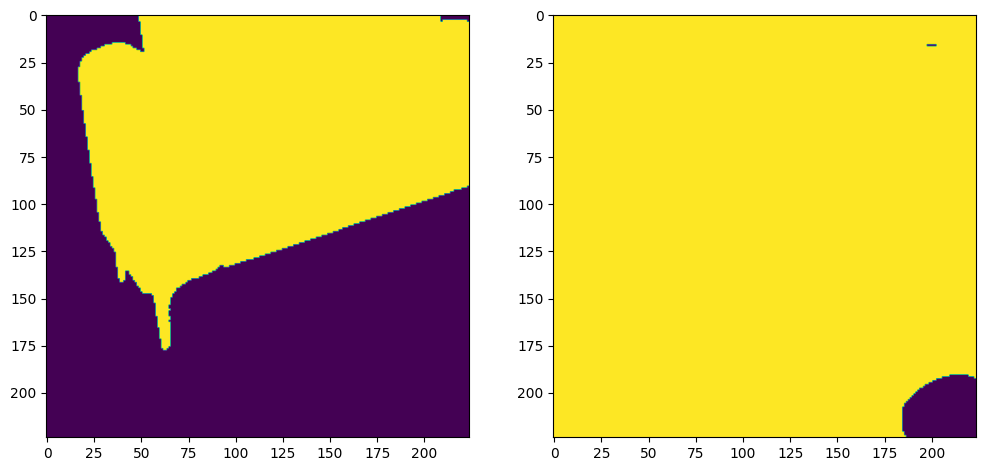

In [ ]:
test_model(model, *val_ds[57], categories[val_dataset[57]['category']])

Результаты эксперимента демонстрируют, что собственная реализация модели уступает предобученной Segformer. Это, вероятно, объясняется двумя факторами:

- Упрощенная архитектура — наша модель имеет меньше слоев и механизмов внимания по сравнению с Segformer.

- Отсутствие предобучения — в отличие от Segformer, наша реализация обучалась «с нуля» на ограниченных данных.

Однако использование улучшенного бейзлайна оказало значительного положительное влияние, по сравнению с предобученной моделью. Результаты метрик стали намного лучше результатов обычного бейзлайна.